[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/QuickstartDemo.ipynb)

# Quick-Start

In this demo, we'll use `DSSM` and `DeepFM` to perform candidate generating and ranking on MovieLens1M dataset.

## Prepare

This project is under development and has not been packaged yet😣, thus we have to import it as a local module.

1. download the source code
```bash
git clone https://github.com/Wp-Zhang/HandyRec.git
```

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git

Cloning into 'HandyRec'...
remote: Enumerating objects: 1435, done.
remote: Counting objects: 100% (1435/1435), done.
remote: Compressing objects: 100% (1092/1092), done.
remote: Total 1435 (delta 527), reused 1121 (delta 293), pack-reused 0
Receiving objects: 100% (1435/1435), 20.18 MiB | 11.12 MiB/s, done.
Resolving deltas: 100% (527/527), done.


2. add the project location to system path so that we can import it as a local module

In [2]:
import sys
sys.path.append('./HandyRec/')

The next step is downloading the dataset:
```bash
wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
unzip -o ml-1m.zip
```

In [3]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
!unzip -o ml-1m.zip

--2022-04-03 18:11:38--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  3.40MB/s    in 1.7s    

2022-04-03 18:11:41 (3.40 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [4]:
!pip install faiss-gpu #faiss-cpu

     |████████████████████████████████| 85.5 MB 92 kB/s 


## Import modules

In [5]:
from handyrec.dataset.movielens import MovieMatchDataHelper, MovieRankDataHelper
from handyrec.dataset.metrics import map_at_k, recall_at_k
from handyrec.layers.utils import sampledsoftmaxloss
from handyrec.features import DenseFeature, SparseFeature, SparseSeqFeature, FeatureGroup, EmbdFeatureGroup, FeaturePool
from handyrec.models.match import DSSM
from handyrec.models.rank import DeepFM
from handyrec.models.utils import search_embedding


import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Prepare data for matching

Load data into a dictionary with three keys: `user`, `item`, and `interact`

In [7]:
match_dh = MovieMatchDataHelper('./ml-1m/')
data = match_dh.get_clean_data(sparse_features=['gender','age','occupation','zip','year'])

Encode Item Sparse Feats: 100%|██████████| 1/1 [00:00<00:00, 240.39it/s]


In [8]:
match_u_dense_feats = [] # * as there is no user dense features, this is an empty list
match_u_sparse_feats = ['user_id','gender','age','occupation','zip']
match_i_dense_feats = [] # * as there is no item dense features, this is an empty list
match_i_sparse_feats = [f for f in data['item'].columns if f != 'title']

match_u_feats = match_u_dense_feats + match_u_sparse_feats
match_i_feats = match_i_dense_feats + match_i_sparse_feats

Only movies with ratings larger than `3` are treated as 'positive' samples for each user. Every last `10` 'positive' movies of each user are held out for testing.

The maximum length of user watch history is set as `40`. As we'll use sampled softmax in the training process of the match model, we don't need to generate negative samples by ourselves, thus `negnum` is set as `0`.

In [9]:
match_dh.gen_dataset(match_u_feats + match_i_feats, data, seq_max_len=40, negnum=0, min_rating=3, n=10)
match_train, match_train_label, match_test, match_test_label = match_dh.load_dataset(match_u_feats, match_i_feats)

Load movie Features: 100%|██████████| 3/3 [00:00<00:00, 210.72it/s]


## Train match model and export embeddings

Initialize a `FeaturePool` instance to store features used for training.

In [10]:
feat_pool1 = FeaturePool()

Get dimension of sparse features:

In [11]:
match_feature_dim = match_dh.get_feature_dim(data, match_u_feats, match_i_feats, [])

Initialize an `EmbdFeatureGroup` instance for item features.

In [12]:
all_item_feat_values = {f:np.array(data['item'][f].tolist()) for f in match_i_feats}
match_i_sparse_feats.remove('genres')
match_item_features = [SparseFeature(x, vocab_size=match_feature_dim[x], embedding_dim=64) for x in match_i_sparse_feats] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, 64), 'genres', seq_len=6)]
item_feature_group = EmbdFeatureGroup(
    name='item', 
    id_name='movie_id', 
    features=match_item_features, 
    feature_pool=feat_pool1, 
    value_dict=all_item_feat_values,
    embd_dim=64
)

Initialize a `FeatureGroup` instance for user features.

In [13]:
match_u_feats = [SparseFeature(x, match_feature_dim[x], 64) for x in match_u_sparse_feats] +\
                [SparseSeqFeature(item_feature_group, 'hist_movie_id',seq_len=40)]
user_feature_group = FeatureGroup('user', match_u_feats, feat_pool1)

Create a DSSM model.

In [14]:
match_model = DSSM(
    user_feature_group, item_feature_group,
    user_dnn_hidden_units=(256,128,64), 
    item_dnn_hidden_units=(128,64), 
    dnn_dropout=0.1,
    dnn_bn=True,
    num_sampled=100
)

Let's take a look at the model structure:

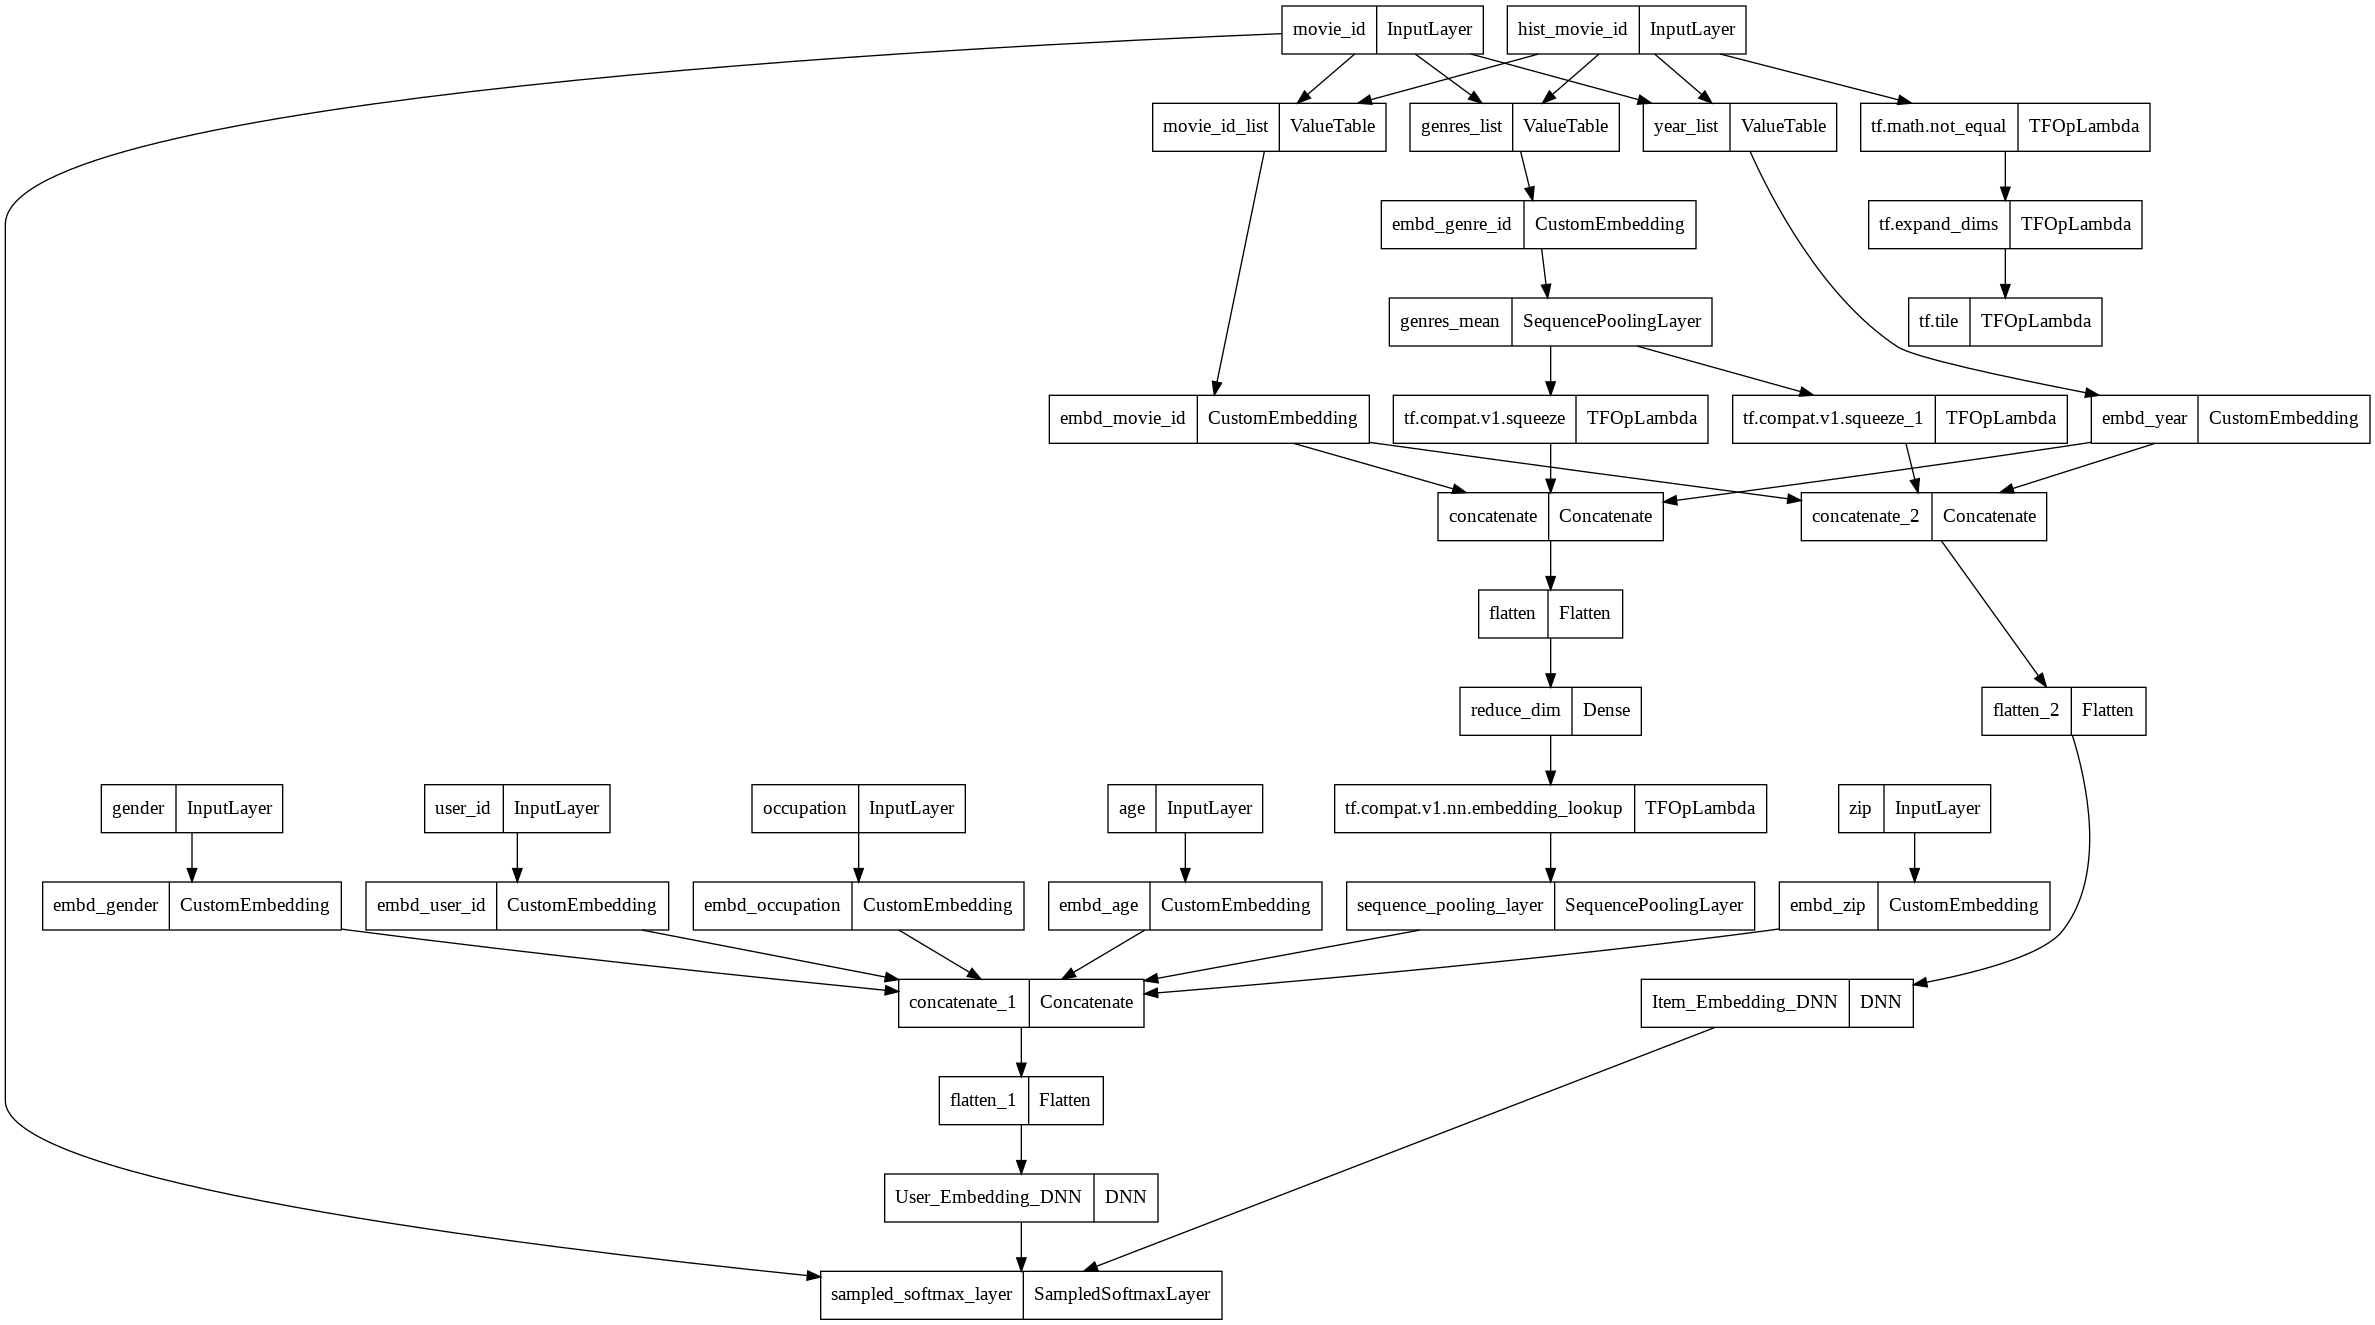

In [15]:
plot_model(match_model)

In [16]:
match_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=sampledsoftmaxloss)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./match_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = match_model.fit(match_train, match_train_label,
                            batch_size=2**12, 
                            epochs=25,
                            verbose=1,
                            validation_split=0.1,
                            callbacks=[early_stop,checkpoint])
match_model.load_weights('./match_checkpoint/')

Epoch 1/25
171/171 [==============================] - 11s 27ms/step - loss: 6.4752 - val_loss: 3.8319
Epoch 2/25
171/171 [==============================] - 4s 22ms/step - loss: 3.5348 - val_loss: 3.5900
Epoch 3/25
171/171 [==============================] - 4s 20ms/step - loss: 3.2867 - val_loss: 3.1478
Epoch 4/25
171/171 [==============================] - 4s 21ms/step - loss: 3.1181 - val_loss: 2.9211
Epoch 5/25
171/171 [==============================] - 3s 20ms/step - loss: 2.9992 - val_loss: 2.9371
Epoch 6/25
171/171 [==============================] - 4s 21ms/step - loss: 2.8963 - val_loss: 2.6634
Epoch 7/25
171/171 [==============================] - 3s 20ms/step - loss: 2.8123 - val_loss: 2.6709
Epoch 8/25
171/171 [==============================] - 4s 21ms/step - loss: 2.7323 - val_loss: 2.6727
Epoch 9/25
171/171 [==============================] - 4s 21ms/step - loss: 2.7100 - val_loss: 2.5721
Epoch 10/25
171/171 [==============================] - 4s 22ms/step - loss: 2.6302 - val_l

Get user and movie embeddings:

In [17]:
user_embedding_model = Model(inputs=match_model.user_input, outputs=match_model.user_embedding)
item_embedding_model = Model(inputs=match_model.item_input, outputs=match_model.item_embedding)

user_embs = user_embedding_model.predict(match_test, batch_size=2 ** 15)
item_embs = item_embedding_model.predict(all_item_feat_values, batch_size=2 ** 15)

print(user_embs.shape)
print(item_embs.shape)

(6032, 64)
(3883, 64)


## Test match model

In [18]:
candidates = search_embedding(
    64, 
    item_embs, 
    user_embs,
    data['item']['movie_id'].values,
    n=100,
    gpu=True)

In [19]:
map_at_k(match_test_label, candidates, k=10)

0.022409043303439857

In [20]:
recall_at_k(match_test_label, candidates, k=10)

0.056482095490716186

In [21]:
recall_at_k(match_test_label, candidates, k=100)

0.3385775862068966

## Prepare data for ranking

In [23]:
test_user_embs = user_embedding_model.predict(match_test, batch_size=2 ** 15)
test_candidates = search_embedding(
    64, 
    item_embs, 
    test_user_embs,
    data['item']['movie_id'].values,
    n=100,
    gpu=True)

test_candidates = {match_test['user_id'][i] : test_candidates[i] for i in range(test_candidates.shape[0])}

In [24]:
del user_embs, item_embs, match_train, match_train_label, test_user_embs
gc.collect()

3871

For ranking dataset, We'll generate `10` random negative samples for each positive sample.

In [25]:
rank_dh = MovieRankDataHelper('./ml-1m/')
rank_u_sparse_feats = ['user_id','gender','age','occupation', 'zip']
rank_i_sparse_feats = [f for f in data['item'].columns if f != 'title']

rank_dh.gen_dataset(rank_u_sparse_feats+rank_i_sparse_feats, data, test_candidates, seq_max_len=40, negnum=10)
rank_train, rank_train_label, rank_test = rank_dh.load_dataset(rank_u_sparse_feats, rank_i_sparse_feats)

Load movie Features: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


In [26]:
rank_feature_dim = rank_dh.get_feature_dim(data, rank_u_sparse_feats, rank_i_sparse_feats, [])

## Train rank model and recommend movies

Initialize a `FeaturePool` instance to store features used for training.

In [27]:
feat_pool2 = FeaturePool()

In [28]:
rank_sparse_feats = rank_u_sparse_feats + rank_i_sparse_feats

Initialize a `FeatureGroup` instance for features used in FM.

In [29]:
rank_sparse_feats.remove('genres')
rank_fm_features = [SparseFeature(x, rank_feature_dim[x], 64) for x in rank_sparse_feats] +\
                    [SparseSeqFeature(SparseFeature('genre_id', 19, 64), 'genres',6)] +\
                   [SparseSeqFeature(SparseFeature('movie_id', rank_feature_dim['movie_id'], 64), 'hist_movie_id', 40)]
fm_feature_group = FeatureGroup('fm', rank_fm_features, feat_pool2)

Initialize a `FeatureGroup` instance for features used in DNN.

In [30]:
rank_dnn_feats = rank_fm_features
dnn_feature_group = FeatureGroup('dnn', rank_dnn_feats, feat_pool2)

Create a DeepFM model:

In [31]:
rank_model = DeepFM(
    fm_feature_group, dnn_feature_group, 
    dnn_hidden_units=(256,128,1), dnn_dropout=0.2, l2_dnn=0.2, dnn_bn=True
)

Let's take a look at the model sturcture:

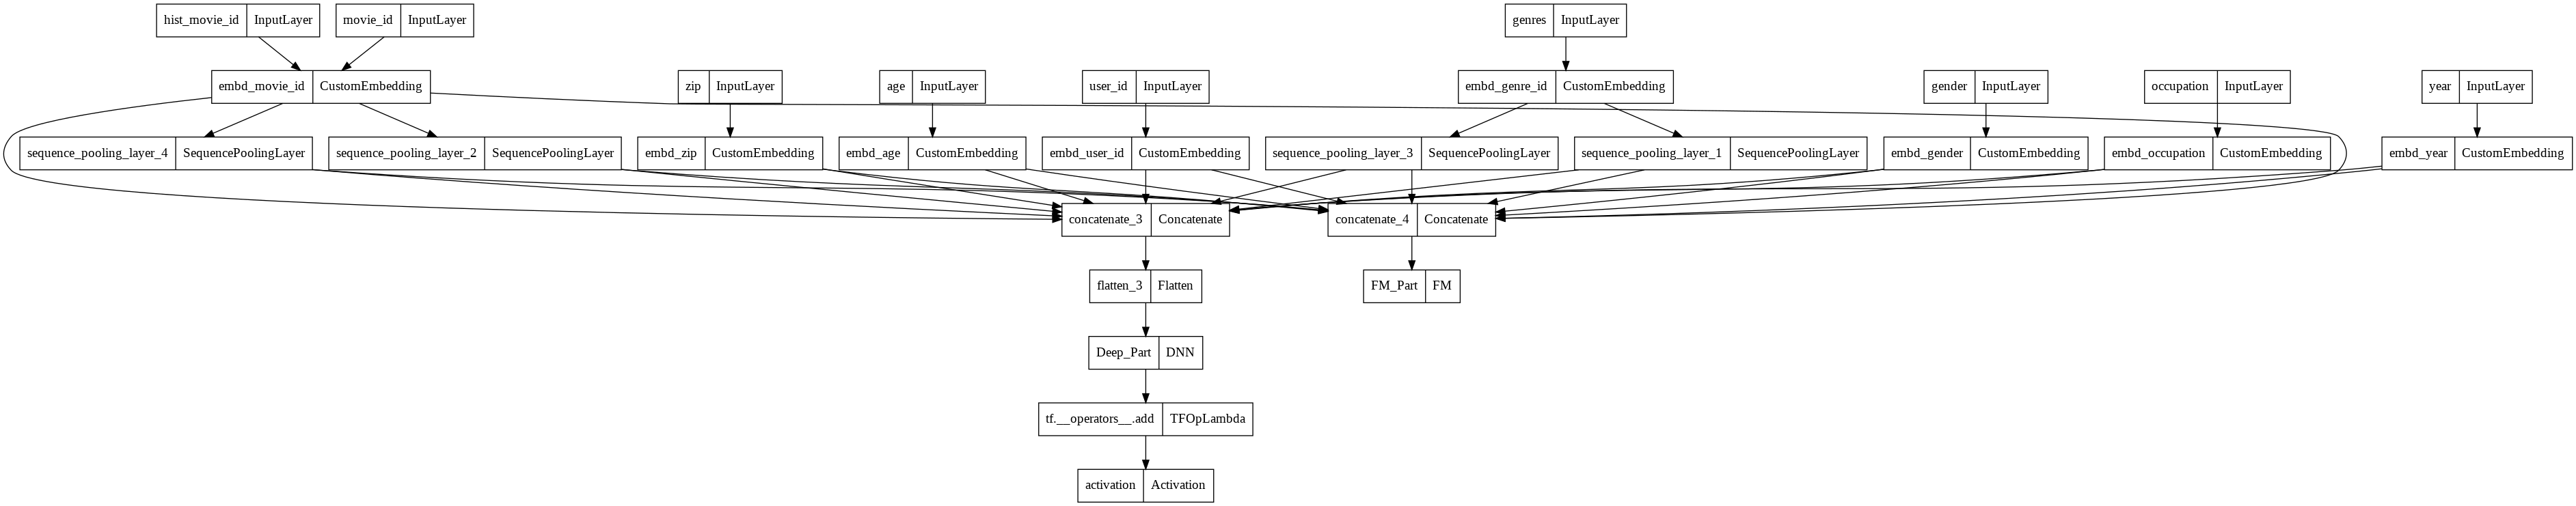

In [32]:
plot_model(rank_model)

In [33]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=binary_crossentropy)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = rank_model.fit(rank_train, rank_train_label,
                    batch_size=2**12, 
                    epochs=25,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stop,checkpoint])
rank_model.load_weights('./rank_checkpoint/')

Epoch 1/25
2272/2272 [==============================] - 83s 35ms/step - loss: 2.8958 - val_loss: 0.1845
Epoch 2/25
2272/2272 [==============================] - 78s 35ms/step - loss: 0.1695 - val_loss: 0.1614
Epoch 3/25
2272/2272 [==============================] - 79s 35ms/step - loss: 0.1510 - val_loss: 0.1555
Epoch 4/25
2272/2272 [==============================] - 79s 35ms/step - loss: 0.1423 - val_loss: 0.1534
Epoch 5/25
2272/2272 [==============================] - 79s 35ms/step - loss: 0.1367 - val_loss: 0.1530
Epoch 6/25
2272/2272 [==============================] - 79s 35ms/step - loss: 0.1338 - val_loss: 0.1535
Epoch 7/25
2272/2272 [==============================] - 79s 35ms/step - loss: 0.1304 - val_loss: 0.1543
Epoch 8/25
2272/2272 [==============================] - 79s 35ms/step - loss: 0.1286 - val_loss: 0.1555
Epoch 9/25
2272/2272 [==============================] - 79s 35ms/step - loss: 0.1273 - val_loss: 0.1563
Epoch 10/25
2272/2272 [==============================] - 79s 35m

In [34]:
del rank_train
gc.collect()

12923

In [35]:
pred = rank_model.predict(rank_test, batch_size=2**12)

In [36]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = rank_test['user_id']
pred_df['movie_id'] = rank_test['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

## Test recommendation result

In [37]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = match_test['user_id']
test_label_df['label'] = match_test_label.tolist()

In [38]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [39]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.01695960170098101

In [40]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.05109416445623343

In [41]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.3385775862068966

**Note**: All parameters in the demo are set for a quick running test purpose, tuning them may lead to a huge increase in model performance.